# Imports

In [1]:
# Libraries
from datetime import datetime
from fancyimpute import IterativeImputer
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fclusterdata
from scipy.stats import ks_2samp

import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

import sqlite3

import umap

# Création des fiches client

## Agrégation

In [2]:
def create_client_cards(filename, query):
    # Checking if the file 'olist.db' exists in the current directory
    if not os.path.isfile(filename):
        # If the file is not found, print an error message and exit the program
        print(f"Le fichier {filename} n'a pas été trouvé dans le répertoire courant.")
        exit()

    # Connecting to the SQLite database 'olist.db'
    conn = sqlite3.connect(filename)

    # Creating a cursor object for executing SQL commands
    cursor = conn.cursor()
    
    data = pd.read_sql_query(query, conn)
    
    # Close the connection
    conn.close()

    return data

## Transformation


In [3]:
def fill_df(data, distances):
    raw_df = data.copy()
    
    ## Feature creation
    # Total spent
    raw_df['total_spent'] = raw_df['nb_orders']*raw_df['average_basket']
    
    # Distance from warehouse
    raw_df['distance_to_warehouse'] = raw_df['customer_state'].map(distances)
    
    return raw_df

### Imputation

In [4]:
def impute_df(raw_df):
    imputed_df = raw_df.copy()
    
    imputed_df['average_review_score'].fillna(3, inplace=True)
    
    return imputed_df

### Transformation des types de colonne

In [5]:
def transform_df(imputed_df):
    transformed_df = imputed_df.copy()
    
    # Convertir les colonnes float en float32
    transformed_df[['seniority', 'average_review_score', 'nb_articles_moyen_par_commande', 'nb_categories_moyen_par_commande', 'average_basket', 'total_spent', 'avg_freight_value']] = transformed_df[['seniority', 'average_review_score', 'nb_articles_moyen_par_commande', 'nb_categories_moyen_par_commande', 'average_basket', 'total_spent', 'avg_freight_value']].astype('float32')

    # Convertir les colonnes int en int16
    transformed_df[['nb_reviews', 'nb_orders', 'nb_mode_paiement', 'nb_canceled', 'distance_to_warehouse']] = transformed_df[['nb_reviews', 'nb_orders', 'nb_mode_paiement', 'nb_canceled', 'distance_to_warehouse']].astype('int16')
    
    return transformed_df

### Scaler

In [6]:
def scale_df(transformed_df):
    scaled_df = transformed_df.copy()
    
    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_df[scaled_df.select_dtypes(exclude='object').columns] = scaler.fit_transform(scaled_df.select_dtypes(exclude='object'))

    # Encodage One-Hot
    scaled_df = pd.get_dummies(scaled_df, columns=['customer_state', 'mode_de_paiement_majoritaire'])

    return scaled_df

In [7]:
def create_df(filename, query, distances):
    data = create_client_cards(filename, query)
    raw_df = fill_df(data, distances)
    imputed_df = impute_df(raw_df)
    transformed_df = transform_df(imputed_df)
    scaled_df = scale_df(transformed_df)
    df = scaled_df.copy()
    
    return df

In [8]:
filename = 'olist.db'

In [10]:
query = """
WITH order_items_count AS (
  SELECT
    order_id,
    COUNT(*) AS nb_articles,
    COUNT(DISTINCT product_id) AS nb_categories,
    AVG(freight_value) AS avg_freight_value
  FROM
    order_items
  GROUP BY
    order_id
), customer_averages AS (
  SELECT
    o.customer_id,
    AVG(oic.nb_articles) AS nb_articles_moyen_par_commande,
    AVG(oic.nb_categories) AS nb_categories_moyen_par_commande,
    AVG(oic.avg_freight_value) AS avg_freight_value
  FROM
    orders o
  JOIN
    order_items_count oic ON o.order_id = oic.order_id
  GROUP BY
    o.customer_id
), payment_counts AS (
  SELECT
    order_id,
    payment_type,
    COUNT(*) AS count
  FROM
    order_pymts
  GROUP BY
    order_id,
    payment_type
), major_payment AS (
  SELECT
    order_id,
    payment_type AS mode_de_paiement_majoritaire
  FROM
    payment_counts
  WHERE
    (order_id, count) IN (
      SELECT
        order_id,
        MAX(count)
      FROM
        payment_counts
      GROUP BY
        order_id
    )
), payment_modes AS (
  SELECT
    o.customer_id,
    COUNT(DISTINCT op.payment_type) AS nb_mode_paiement
  FROM
    orders o
  JOIN
    order_pymts op ON o.order_id = op.order_id
  GROUP BY
    o.customer_id
)
SELECT
  c.customer_unique_id,
  (JULIANDAY('2018-10-17') - JULIANDAY(MIN(o.order_purchase_timestamp))) AS seniority,
  COUNT(DISTINCT or_reviews.order_id) AS nb_reviews,
  AVG(or_reviews.review_score) AS average_review_score,
  COUNT(DISTINCT o.order_id) AS nb_orders,
  AVG(oi.price) AS average_basket,
  SUM(CASE WHEN o.order_status = 'canceled' THEN 1 ELSE 0 END) AS nb_canceled,
  ca.nb_articles_moyen_par_commande,
  ca.nb_categories_moyen_par_commande,
  c.customer_state,
  mp.mode_de_paiement_majoritaire,
  pm.nb_mode_paiement,
  ca.avg_freight_value
FROM
  customers c
JOIN
  orders o ON c.customer_id = o.customer_id
LEFT JOIN
  order_reviews or_reviews ON o.order_id = or_reviews.order_id
JOIN
  order_items oi ON o.order_id = oi.order_id
JOIN
  customer_averages ca ON c.customer_id = ca.customer_id
LEFT JOIN
  major_payment mp ON o.order_id = mp.order_id
JOIN
  payment_modes pm ON c.customer_id = pm.customer_id
GROUP BY
  c.customer_unique_id;
"""

In [11]:
distances = {
    'SP': 350,  # São Paulo
    'SC': 250,  # Santa Catarina
    'PA': 3000, # Pará
    'PR': 0,    # Paraná (Curitiba is the capital)
    'RJ': 1000, # Rio de Janeiro
    'MA': 3500, # Maranhão
    'ES': 1200, # Espírito Santo
    'RS': 500,  # Rio Grande do Sul
    'MG': 1000, # Minas Gerais
    'GO': 1200, # Goiás
    'DF': 1500, # Distrito Federal
    'BA': 2500, # Bahia
    'MT': 2000, # Mato Grosso
    'SE': 2500, # Sergipe
    'TO': 3000, # Tocantins
    'PE': 3500, # Pernambuco
    'CE': 4000, # Ceará
    'AL': 3500, # Alagoas
    'AC': 4000, # Acre
    'PI': 3500, # Piauí
    'PB': 3000, # Paraíba
    'RN': 3000, # Rio Grande do Norte
    'AM': 4000, # Amazonas
    'MS': 1000, # Mato Grosso do Sul
    'RR': 4500, # Roraima
    'AP': 4500, # Amapá
    'RO': 4000, # Rondônia
}

In [12]:
test_df = create_df(filename, query, distances)

In [29]:
percent_clients_with_multiple_order = len(test_df[test_df['nb_orders']>1])/len(test_df)
print(f"Clients ayant effectuer plus d'une commande : {(percent_clients_with_multiple_order*100):.2f} %")

Clients ayant effectuer plus d'une commande : 3.05 %


# Création des dfs

In [16]:
start_date = pd.to_datetime('2017-09-01')
#absolute_start_date = pd.to_datetime('2016-09-01')
end_date = pd.to_datetime('2018-03-01')
final_end_date = pd.to_datetime('2018-09-01')

dfs_months = []

n_weeks = int((final_end_date - end_date)/np.timedelta64(2, 'W'))

conn = sqlite3.connect('olist.db')

# Création des dataframes pour chaque période de mois
for i in range(0, n_weeks-1):
    print(end_date.strftime('%Y-%m-%d'), '...')
    data = pd.read_sql_query(f"""
        WITH order_items_count AS (
          SELECT
            order_id,
            COUNT(*) AS nb_articles,
            COUNT(DISTINCT product_id) AS nb_categories,
            AVG(freight_value) AS avg_freight_value
          FROM
            order_items
          GROUP BY
            order_id
        ), customer_averages AS (
          SELECT
            o.customer_id,
            AVG(oic.nb_articles) AS nb_articles_moyen_par_commande,
            AVG(oic.nb_categories) AS nb_categories_moyen_par_commande,
            AVG(oic.avg_freight_value) AS avg_freight_value
          FROM
            orders o
          JOIN
            order_items_count oic ON o.order_id = oic.order_id
          WHERE
            o.order_purchase_timestamp BETWEEN '{start_date.strftime('%Y-%m-%d')}' AND '{end_date.strftime('%Y-%m-%d')}'
          GROUP BY
            o.customer_id
        ), payment_counts AS (
          SELECT
            order_id,
            payment_type,
            COUNT(*) AS count
          FROM
            order_pymts
          GROUP BY
            order_id,
            payment_type
        ), major_payment AS (
          SELECT
            order_id,
            payment_type AS mode_de_paiement_majoritaire
          FROM
            payment_counts
          WHERE
            (order_id, count) IN (
              SELECT
                order_id,
                MAX(count)
              FROM
                payment_counts
              GROUP BY
                order_id
            )
        ), payment_modes AS (
          SELECT
            o.customer_id,
            COUNT(DISTINCT op.payment_type) AS nb_mode_paiement
          FROM
            orders o
          JOIN
            order_pymts op ON o.order_id = op.order_id
          WHERE
            o.order_purchase_timestamp BETWEEN '{start_date.strftime('%Y-%m-%d')}' AND '{end_date.strftime('%Y-%m-%d')}'
          GROUP BY
            o.customer_id
        )
        SELECT
          c.customer_unique_id,
          (JULIANDAY('2018-10-17') - JULIANDAY(MIN(o.order_purchase_timestamp))) AS seniority,
          COUNT(or_reviews.order_id) AS nb_reviews,
          AVG(or_reviews.review_score) AS average_review_score,
          COUNT(o.order_id) AS nb_orders,
          AVG(oi.price) AS average_basket,
          SUM(CASE WHEN o.order_status = 'canceled' THEN 1 ELSE 0 END) AS nb_canceled,
          ca.nb_articles_moyen_par_commande,
          ca.nb_categories_moyen_par_commande,
          c.customer_state,
          mp.mode_de_paiement_majoritaire,
          pm.nb_mode_paiement,
          ca.avg_freight_value
        FROM
          customers c
        JOIN
          orders o ON c.customer_id = o.customer_id
        LEFT JOIN
          order_reviews or_reviews ON o.order_id = or_reviews.order_id
        JOIN
          order_items oi ON o.order_id = oi.order_id
        JOIN
          customer_averages ca ON c.customer_id = ca.customer_id
        LEFT JOIN
          major_payment mp ON o.order_id = mp.order_id
        JOIN
          payment_modes pm ON c.customer_id = pm.customer_id
        WHERE
          o.order_purchase_timestamp BETWEEN '{start_date.strftime('%Y-%m-%d')}' AND '{end_date.strftime('%Y-%m-%d')}'
        GROUP BY
          c.customer_unique_id
        """, conn)

    raw_df = fill_df(data, distances)
    imputed_df = impute_df(raw_df)
    transformed_df = transform_df(imputed_df)
    df_months = scale_df(transformed_df)
        
    # Ajout d'un préfixe au nom du dataframe pour indiquer la période de mois correspondante
    dfs_months.append(df_months)
    
    end_date = end_date + pd.DateOffset(weeks=2)
conn.close()

2018-03-01 ...
2018-03-15 ...
2018-03-29 ...
2018-04-12 ...
2018-04-26 ...
2018-05-10 ...
2018-05-24 ...
2018-06-07 ...
2018-06-21 ...
2018-07-05 ...
2018-07-19 ...
2018-08-02 ...


# Kmeans

In [17]:
features = ['nb_orders', 'average_review_score', 'average_basket', 'nb_articles_moyen_par_commande',]

In [18]:
dfs_months[0][features].describe()

,nb_orders,average_review_score,average_basket,nb_articles_moyen_par_commande
count,3.492800e+04,3.492800e+04,3.492800e+04,3.492800e+04
mean,-1.354279e-08,-6.334529e-09,-9.829442e-10,-1.671005e-08
std,1.000133e+00,1.000103e+00,1.000005e+00,1.000083e+00
min,-3.014578e-01,-2.185296e+00,-7.025657e-01,-2.601937e-01
25%,-3.014578e-01,-7.338457e-01,-4.661989e-01,-2.601937e-01
50%,-3.014578e-01,7.176040e-01,-2.571790e-01,-2.601937e-01
75%,-3.014578e-01,7.176040e-01,9.641301e-02,-2.601937e-01
max,3.331986e+01,7.176040e-01,2.070868e+01,3.406841e+01


### Paramétrage des centroides initiaux (obsolète)

In [19]:
# Nombre de clusters : 4
# Nombre de features : 4

fixed_centroids = np.array([
            [0, 0.5, 0, 0],  
            [0, -1.5, 0, 0],  
            [4.5, -0.5, 0, 4.5],  
            [0, 0, 4.5, 0]  
        ])

### Entraînement de tous les df

In [ ]:
# Entraîner un modèle KMeans sur le premier DataFrame de la liste
kmeans_first = KMeans(n_clusters=4, random_state=18, n_init=10, init=fixed_centroids)
kmeans_first.fit(dfs_months[0][features])

# Conserver les étiquettes de cluster pour le jeu de données de test avec le premier modèle
labels_test_first = kmeans_first.predict(test_df[features])

# Liste pour conserver les ARI scores de la première méthode de comparaison
ari_scores_first = []

for df_months in dfs_months[1:]:  # Ignorer le premier DataFrame

    # Entraîner un modèle KMeans sur le DataFrame actuel
    kmeans = KMeans(n_clusters=4, random_state=18, n_init=10, init=fixed_centroids)
    kmeans.fit(df_months[features])

    # Tester les prédictions sur le jeu de données de test
    labels_test_current = kmeans.predict(test_df[features])

    # Calculer le ARI score entre les prédictions du premier modèle et celles du modèle actuel
    ari_score = adjusted_rand_score(labels_test_first, labels_test_current)
    ari_scores_first.append(ari_score)

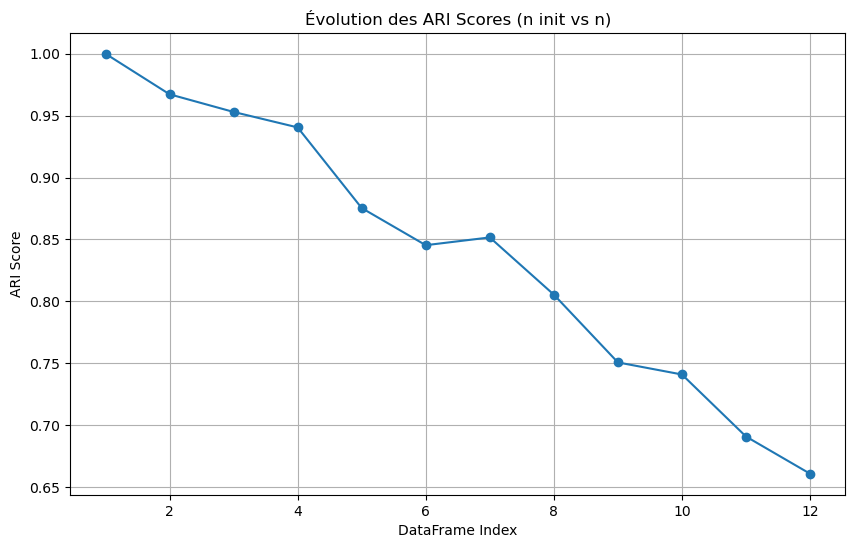

In [28]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(dfs_months)), ari_scores_first, marker='o')
plt.xlabel("DataFrame Index")
plt.ylabel("ARI Score")
plt.title("Évolution des ARI Scores (n init vs n)")
plt.grid(True)
plt.show()

# Annexe

In [ ]:
# Fonction pour entraîner le modèle K-means et obtenir les labels
def train_and_predict(df, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=18)
    return kmeans.fit(df[features])

# Fonction pour calculer les métriques
def calculate_metrics(df, labels):
    silhouette = silhouette_score(df[features], labels)
    return silhouette

# Fonction pour effectuer le test de Kolmogorov-Smirnov
def ks_test(base_df, current_df):
    results = {}
    for column in features:
        statistic, p_value = ks_2samp(base_df[column], current_df[column])
        results[column] = {'statistic': statistic, 'p_value': p_value}
    return results

In [ ]:
# Entraînement du modèle initial sur les 6 premiers mois
base_df = dfs_months[0]
base_model = train_and_predict(base_df)

In [ ]:
for df in dfs_months:
    print(df.shape)

In [ ]:
base_labels_test = base_model.predict(test_df[features])

In [ ]:
# Initialisation des listes pour stocker les résultats
dates = []
silhouette_scores = []
ari_scores = []
centroids_distances = []
ks_results = []

for i, df in enumerate(dfs_months[1:]):  # Commencer après le premier dataframe
    date = pd.to_datetime('2018-03-01') + pd.DateOffset(weeks=2*i)
    dates.append(date)
    
    # Entraînement d'un nouveau modèle sur les données actuelles
    current_model = train_and_predict(df)
    current_labels = current_model.labels_
    
    # Calcul des métriques
    silhouette = calculate_metrics(df, current_labels)
    silhouette_scores.append(silhouette)
    
    # Prédiction sur test_df avec le modèle actuel
    current_labels_test = current_model.predict(test_df[features])
    
    # Calcul de l'ARI score
    ari = adjusted_rand_score(base_labels_test, current_labels_test)
    ari_scores.append(ari)
    
    # Calcul de la distance moyenne entre les centroids initiaux et actuels
    centroid_dist = np.mean([np.linalg.norm(c1-c2) for c1, c2 in zip(base_model.cluster_centers_, current_model.cluster_centers_)])
    centroids_distances.append(centroid_dist)
    
    # Test de Kolmogorov-Smirnov par rapport au premier dataframe de 6 mois
    ks_result = ks_test(base_df, df)
    ks_results.append(ks_result)

In [ ]:
results_df = pd.DataFrame({
    'Date': dates,
    'Silhouette Score': silhouette_scores,
    'ARI Score': ari_scores,
    'Centroids Distance': centroids_distances
})

# Affichage des résultats
results_df

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Scores', color='tab:blue')
ax1.plot(results_df['Date'], results_df['Silhouette Score'], color='tab:blue', label='Silhouette Score')
ax1.plot(results_df['Date'], results_df['ARI Score'], color='tab:green', label='ARI Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Centroids Distance', color='tab:orange')
ax2.plot(results_df['Date'], results_df['Centroids Distance'], color='tab:orange', label='Centroids Distance')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Évolution des métriques de clustering au fil du temps')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

# Analyse des résultats du test KS
for i, ks_result in enumerate(ks_results):
    print(f"\nRésultats du test KS pour la période {dates[i]}:")
    for column, result in ks_result.items():
        print(f"{column}: Statistic = {result['statistic']:.4f}, p-value = {result['p_value']:.4f}")